<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/scores_cnn_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git
# Change directory into cloned repo
%cd MADSmilestone2
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 718, done.
remote: Counting objects: 100% (718/718), done.
remote: Compressing objects: 100% (611/611), done.
remote: Total 718 (delta 386), reused 229 (delta 97), pack-reused 0
Receiving objects: 100% (718/718), 7.04 MiB | 38.00 KiB/s, done.
Resolving deltas: 100% (386/386), done.
/content/MADSmilestone2


In [3]:
!pip install torchmetrics boto3

     |████████████████████████████████| 282 kB 4.1 MB/s 
     |████████████████████████████████| 131 kB 73.6 MB/s 
     |████████████████████████████████| 7.9 MB 80.8 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 138 kB 85.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
# General Libraries
import pandas as pd
import numpy as np
import ast
import logging
import os
import boto3
from botocore.exceptions import ClientError
import requests
import botocore
import tempfile

# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchmetrics

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
#response = client.list_buckets()

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [6]:
#epochs = 2
train_batch_size = 8
val_batch = 4
test_batch = 1
learning_rate = 1e-3
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
weight_decay = 1e-5
# Define file extension to use for new data saves
extension_ = "res_netfp"
# Normalize data if rgb and set rgb_val to True to convert 
normalize_ = 'True'
# Define which round to get data from
rnd = 10 #1,2,3,4,6,7,8,9
# Define model extensions for naming file (which model do we want to train on)
model_ext = "res_netfp"
# m = 'First model'
# m = 'pre-trained'
m = 'pre-trained-res'
# m = 'resnet'

In [7]:
def open_dict(path):
    """Takes in path and opens file"""

    cust_file = open(path, "r")
    contents = cust_file.read()
    dictionary = ast.literal_eval(contents)
    cust_file.close()

    return dictionary


dictionarytr = open_dict(
    "/content/MADSmilestone2/Data/Dictionaries/score_dicts/tr_scor_dict_bal.txt"
)
dictionaryv = open_dict(
    "/content/MADSmilestone2/Data/Dictionaries/score_dicts/val_scor_dict_nobal.txt"
)
dictionaryts = open_dict(
    "/content/MADSmilestone2/Data/Dictionaries/score_dicts/tst_scor_dict_nobal.txt"
)

In [8]:
for id, val in dictionarytr.items():
  print("Round {} length is {}".format(str(id), str(len(val))))

Round 9 length is 1936
Round 7 length is 2413
Round 8 length is 2211
Round 4 length is 1740
Round 2 length is 2617
Round 10 length is 1464
Round 5 length is 3367
Round 6 length is 2740
Round 3 length is 1976
Round 1 length is 3536


In [9]:
class ResizedClocks:
    # Resized clock drawing dataset

    def __init__(self, round, round_labels, rgb=None, transform=None):

        # Args:
        # round (int): Round to grab images from.
        # values (list of tuples): Corresponding values for the round.

        self.round = round
        self.vals = round_labels
        self.client = boto3.client(
            "s3", aws_access_key_id=pubkey, aws_secret_access_key=seckey
        )
        self.transform = transform
        self.rgb = rgb

    def __len__(self):
        return len(self.vals)

    # def get_labels(self, idx):
    # return self.vals[idx][1]#self.vals[:, 1]

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = torch.tensor(int(self.vals[idx][1]))
        bucket = "clockimages"  # "test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif"  # f"{self.round}_{spid}.tif"
        # filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
            client.download_file(bucket, obj_name, temp.name)  # filename)

            im = Image.open(temp.name)  # filename)

            if self.rgb:
                #print('rgb')
                gray = im.convert('RGB')
            
            else:
                #print('gray')
                gray = im.convert('1')

            resized = gray.resize((160, 207))  # 284, 368))#(2560, 3312))
            # resized = gray.resize((512, 662))
            im_arr = np.float32(np.array(resized))  # .astype(float)

            if self.transform:
                im_arr = self.transform(im_arr)

            # sample = {'image': im_arr, 'label': label}

            temp.close()

            return im_arr, label

        except botocore.exceptions.ClientError as e:
            return


In [10]:
def collate_fn(batch):
  """From pytorch - way to bypass corrupt or non-existent data"""
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.dataloader.default_collate(batch)

In [11]:
# initialize transformation: data to tensor and normalize
# Could probably resize using torch.transforms
if normalize_ == "True":
    processes = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    rgb_val = "True"
else:
    processes = transforms.ToTensor()
    rgb_val = None
    

In [12]:
train_set = ResizedClocks(rnd, dictionarytr[rnd], transform = processes, rgb = rgb_val)
val_set = ResizedClocks(rnd, dictionaryv[rnd], transform = processes, rgb = rgb_val)
test_set = ResizedClocks(rnd, dictionaryts[rnd], transform = processes, rgb = rgb_val)

In [13]:
# Define Dataloaders for the network
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle = True, num_workers = 6, collate_fn=collate_fn) 
validate_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch, shuffle = True, num_workers = 6, collate_fn=collate_fn) #64, 8,1

In [14]:
# For round 10, there are some corrupt data that when batched at size 1 is not taken
# care of by the collate function, but Nonechucks library skips the missing data and 
# moves on, replacing that missing data index with the next piece of data
# could probably just use this in place of collate for all the loading
if rnd == 10:
  !pip install nonechucks
  import nonechucks as nc
  test_set_safe = nc.SafeDataset(test_set)
  test_loader = torch.utils.data.DataLoader(test_set_safe, batch_size = test_batch, shuffle = False)
else:
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch, shuffle = False, collate_fn=collate_fn)

nonechucks may not work properly with this version of PyTorch (1.9.0+cu102). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [15]:
def set_model(m, model_ext, device):

    if torch.cuda.is_available():
        print("First Model training on GPU")

        if m == "First model":
            # Create model object
            model = ConvNet()
            model = model.to(device)  # (float).cuda()

        elif m == "pre-trained":
            mPATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}".format(
                model_ext
            )
            model = ConvNet()
            model.load_state_dict(torch.load(mPATH))
            model.to(device)
            print("New Model{} training on GPU".format(model_ext))

        elif m == "resnet":
            model = models.resnet50(pretrained=True)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 6)
            model = model.to(device)
            print("RESNET Model training on GPU")

        elif m == "pre-trained-res":
            mPATH = "/content/gdrive/MyDrive/Colab_Notebooks/cnn_1run.model{}".format(
                model_ext
            )
            model = models.resnet50()
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 6)
            model.load_state_dict(torch.load(mPATH))
            model.to(device)
            print("New Model{} training on GPU".format(model_ext))

    else:
        print("CUDA is not available. Turn on GPU")

    return model

In [16]:
def accuracy(y_pred, y_test):
  # Calculating model accuracy at each epoch 
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  correct_pred = (y_pred_prob == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  acc = torch.round(acc * 100)

  return acc

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,  # one input channel gray scale, 16 filters out
            kernel_size=3,
            stride=1,
            padding=1,
        )  # Out:(None,386, 284, 16). ### TRY kernel 7x7 padding 3
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )  # params: (3*3*16*32+32) = 4640
        self.pool1 = nn.MaxPool2d(2, 2)  # Out: (None, 184, 142, 32)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )  # params: (3*3*16*32+32) = 4640
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
        )  # params: (3*3*32*32+32) = 9248
        self.pool2 = nn.MaxPool2d(2, 2)  # Output shape = (None, 92, 71, 64)
        self.bn2 = nn.BatchNorm2d(64)

        # self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128,
        # kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
        self.conv6 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )  # params: (3*3*32*32+32) = 9248
        self.pool3 = nn.MaxPool2d(2, 2)  # Output shape = (None, 46, 35, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.do2 = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(
            128 * 64 * 82, 60
        )  # most recent original size of: 512, 662 -->64 x 82
        self.do3 = nn.Dropout(0.4)  # 40 % probability
        # self.fc3 = nn.Linear(60, 30)
        self.fc2 = nn.Linear(60, 6)  # left with 3 for the three classes

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
        # x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
        x = self.bn3(self.pool3(F.relu(self.conv6((x)))))
        x = self.do2(x)
        x = x.view(x.size(0), 128 * 64 * 82)
        x = F.relu(self.fc1(x))
        x = self.do3(x)
        x = self.fc2(x)
        return x


In [18]:
def train_val_model(epochs):
    for epoch in range(1, epochs + 1):

        train_epoch_loss = 0
        train_epoch_acc = 0

        # set model in training mode
        model.train()
        print("\nEpoch$ : %d" % epoch)
        for x_train_batch, y_train_batch in tqdm(train_loader):
            x_train_batch = x_train_batch.to(
                device
            )  # (float).to(device) # for GPU support
            y_train_batch = y_train_batch.to(device)

            # print(x_train_batch.shape)

            # sets gradients to 0 to prevent interference with previous epoch
            optimizer.zero_grad()

            # Forward pass through NN
            y_train_pred = model(x_train_batch)  # .to(float)
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = accuracy(y_train_pred, y_train_batch)

            # Backward pass, updating weights
            train_loss.backward()
            optimizer.step()

            # Statistics
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()

        with torch.set_grad_enabled(False):
            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for x_val_batch, y_val_batch in tqdm(validate_loader):

                x_val_batch = x_val_batch.to(device)  # .to(float)
                y_val_batch = y_val_batch.to(device)

                # Forward pass
                y_val_pred = model(x_val_batch)  # .to(float)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = accuracy(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        # Prevent plateauing validation loss
        # scheduler.step(val_epoch_loss/len(validate_loader))

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(validate_loader))
        accuracy_stats["train"].append(train_epoch_acc / len(train_loader))
        accuracy_stats["val"].append(val_epoch_acc / len(validate_loader))

        print(
            f"Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validate_loader):.5f}"
        )
        print(
            f"Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(validate_loader):.3f}"
        )



In [19]:
 # Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
# Get model
model = set_model(m, model_ext, device)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

# scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=4)

accuracy_stats = {"train": [], "val": []}

loss_stats = {"train": [], "val": []}

First Model training on GPU
New Modelres_netfp training on GPU


In [21]:
train_val_model(15)


Epoch$ : 1


  0%|          | 0/183 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 43/43 [00:13<00:00,  3.09it/s]


Epoch 001: Train Loss: 0.07389 | Val Loss: 1.71260
Train Acc: 97.749 | Val Acc: 63.605

Epoch$ : 2


100%|██████████| 43/43 [00:13<00:00,  3.16it/s]


Epoch 002: Train Loss: 0.04450 | Val Loss: 1.71739
Train Acc: 98.361 | Val Acc: 65.186

Epoch$ : 3


100%|██████████| 43/43 [00:13<00:00,  3.20it/s]


Epoch 003: Train Loss: 0.11486 | Val Loss: 1.53985
Train Acc: 96.049 | Val Acc: 58.721

Epoch$ : 4


100%|██████████| 43/43 [00:13<00:00,  3.19it/s]


Epoch 004: Train Loss: 0.07598 | Val Loss: 1.79839
Train Acc: 97.934 | Val Acc: 60.860

Epoch$ : 5


100%|██████████| 43/43 [00:13<00:00,  3.13it/s]


Epoch 005: Train Loss: 0.06583 | Val Loss: 1.81970
Train Acc: 97.956 | Val Acc: 63.186

Epoch$ : 6


100%|██████████| 43/43 [00:13<00:00,  3.08it/s]


Epoch 006: Train Loss: 0.03992 | Val Loss: 1.78281
Train Acc: 98.607 | Val Acc: 65.558

Epoch$ : 7


100%|██████████| 43/43 [00:12<00:00,  3.31it/s]


Epoch 007: Train Loss: 0.03141 | Val Loss: 1.97530
Train Acc: 99.257 | Val Acc: 63.791

Epoch$ : 8


100%|██████████| 43/43 [00:13<00:00,  3.17it/s]


Epoch 008: Train Loss: 0.05330 | Val Loss: 1.91532
Train Acc: 98.437 | Val Acc: 58.767

Epoch$ : 9


100%|██████████| 43/43 [00:13<00:00,  3.30it/s]


Epoch 009: Train Loss: 0.06823 | Val Loss: 1.60894
Train Acc: 98.033 | Val Acc: 64.372

Epoch$ : 10


100%|██████████| 43/43 [00:12<00:00,  3.33it/s]


Epoch 010: Train Loss: 0.04543 | Val Loss: 1.65993
Train Acc: 98.612 | Val Acc: 58.930

Epoch$ : 11


100%|██████████| 43/43 [00:13<00:00,  3.13it/s]


Epoch 011: Train Loss: 0.01518 | Val Loss: 1.80211
Train Acc: 99.683 | Val Acc: 60.698

Epoch$ : 12


100%|██████████| 43/43 [00:13<00:00,  3.23it/s]


Epoch 012: Train Loss: 0.02245 | Val Loss: 1.93562
Train Acc: 99.415 | Val Acc: 57.953

Epoch$ : 13


100%|██████████| 43/43 [00:12<00:00,  3.42it/s]


Epoch 013: Train Loss: 0.06932 | Val Loss: 1.97845
Train Acc: 97.902 | Val Acc: 56.023

Epoch$ : 14


100%|██████████| 43/43 [00:13<00:00,  3.19it/s]


Epoch 014: Train Loss: 0.08468 | Val Loss: 1.94746
Train Acc: 97.951 | Val Acc: 56.581

Epoch$ : 15


100%|██████████| 43/43 [00:13<00:00,  3.14it/s]

Epoch 015: Train Loss: 0.03462 | Val Loss: 1.80674
Train Acc: 99.230 | Val Acc: 61.070


In [22]:
# added learning rate decay after 3rd epoch
# 1st: round 1
# 2nd: round 5
# 3rd: round 6 best so far
# 4th: round 7
# 5th (model) saved training on 9
# 6th: round 2
# 7th round 8
# 8th round 3
# 9th round 4
# 10th round 10

In [23]:
# Save GPU model
model_name = 'cnn_1run.model{}'.format(extension_)
PATH = "/content/gdrive/MyDrive/Colab_Notebooks/{}".format(model_name)
torch.save(model.state_dict(), PATH)

# Visualize the Training and Validation


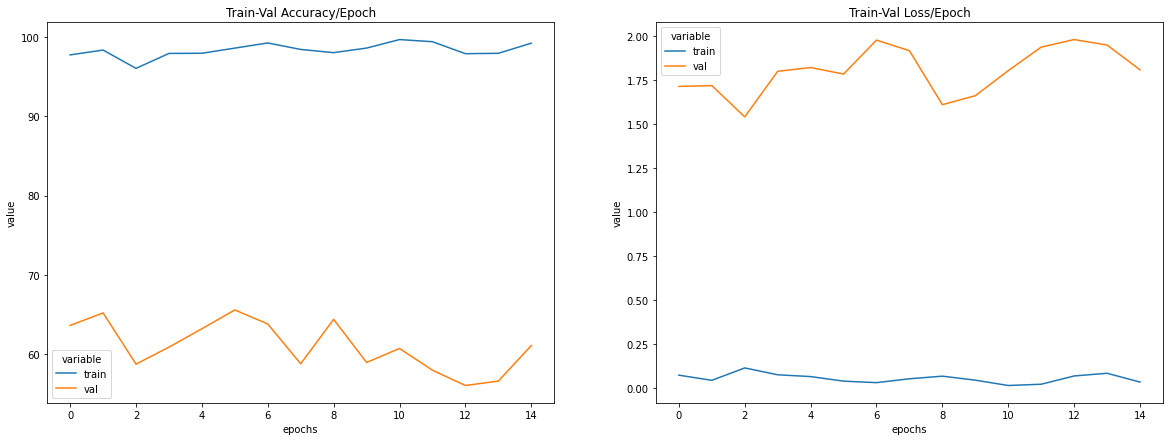

In [25]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab_Notebooks/acc{}.csv'.format(extension_), index = False)
train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab_Notebooks/loss{}.csv'.format(extension_), index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
fig.savefig('/content/gdrive/MyDrive/Colab_Notebooks/acc_loss{}.png'.format(extension_))

# Evaluate the model using Test Set

In [26]:
# Calculate performance
y_test = torch.tensor([])
test_acc = torchmetrics.Accuracy()

with torch.set_grad_enabled(False):
  model.eval()
  #model.to(float)
  for batches in tqdm(test_loader):
    x_test, y_test = batches
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(x_test)
    test_acc(y_pred.cpu(), y_test.cpu())
    total_test_acc = test_acc.compute()
  print('\nTest Acc: ', total_test_acc)
  test_acc.reset()
   

100%|██████████| 179/179 [01:21<00:00,  2.20it/s]


Test Acc:  tensor(0.5754)


## Create Confusion Matrix

In [27]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in tqdm(test_loader):
    x_test_batch = x_test_batch.to(device)#.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

100%|██████████| 179/179 [00:00<00:00, 181.22it/s]


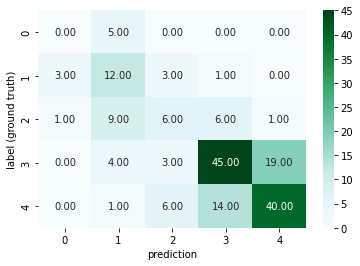

In [28]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('/content/gdrive/MyDrive/Colab_Notebooks/CMTX{}.png'.format(extension_))
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
#class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2,3,4,5]

cr = classification_report(y_test, all_pred, class_vals, output_dict = True)
try:
    cr_file = open('/content/gdrive/MyDrive/Colab_Notebooks/cr{}.txt'.format(extension_), 'wt')
    cr_file.write(str(cr))
    cr_file.close()
  
except:
    print("Unable to write to file")
print(classification_report(y_test, all_pred, class_vals))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         5
           2       0.39      0.63      0.48        19
           3       0.33      0.26      0.29        23
           4       0.68      0.63      0.66        71
           5       0.67      0.66      0.66        61

   micro avg       0.58      0.58      0.58       179
   macro avg       0.34      0.36      0.35       179
weighted avg       0.58      0.58      0.57       179



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot ROC curve

IndexError: ignored

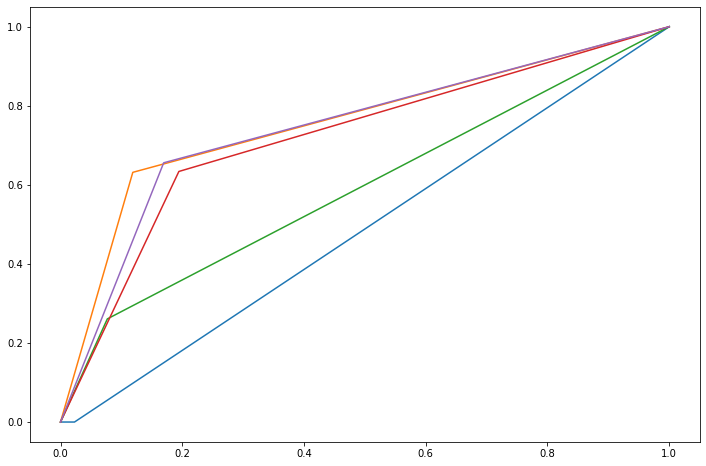

In [30]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2, 3, 4, 5]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test1[:,idx].astype(int), all_pred1[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('/content/gdrive/MyDrive/Colab_Notebooks/roc{}.png'.format(extension_))
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


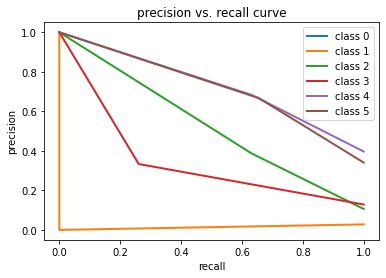

In [32]:
# precision recall curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


# Use label_binarize to be multi-label like settings
y = y_test.numpy()
Y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
Y_pred = label_binarize(all_pred, classes=[0, 1, 2, 3, 4, 5])
n_classes = Y.shape[1]

precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        Y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.savefig('/content/gdrive/MyDrive/Colab_Notebooks/auc_pr{}.png'.format(extension_))
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [ ]:
"""# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)"""

IndexError: ignored

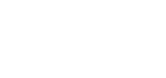

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    class_names = [0,1,2]
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j].squeeze().permute(2,1))# image1.squeeze().permute(1,2,0)
                #imshow(np.transpose(inputs.cpu().data[j], (2, 0, 1)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)  